In [ ]:
cd drive/MyDrive/Colab\ Notebooks/bert_classifier

/content/drive/MyDrive/Colab Notebooks/bert_classifier


In [ ]:
!pip install -qq transformers datasets wordcloud accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# !pip install pyarrow

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
import string
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
## Этот страшный код нужен, чтобы сгрузить датасет прямо напрямую с Каггла.

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'womens-ecommerce-clothing-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F11827%2F16290%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240824%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240824T180513Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04c108a21366ac6b5d78811e97c0da121bf9d23ee834c7f3483df5db35be9787d2c27461461e20bdb2cc466c23517ea01bef880e214ff65a3cf21d62ac49a3febc6b2eb61b3566efb4c1abb650cb3c4a95b8be16f5ecd741e127088c7d9b77bc949c2290bf0c190a2d05a7b1acd56a73d198a154fa2008327acb67cd50e346c8b50a83d52be23e4873b205642ee1c393b3fb101387b950b1f9c1ff4f7e030e5fa3b7054ca1088c30ca1a7b83d970ebcfe037628dbf3e74f2c76ef52237f0ef6464969919b548c9170215d2e708742af8d099bd46355d3561f31d7f4109180394658a3a3cba00c657734d83be1c5b9eb9e5aa9d3398a583556f55a070bedc5530'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2924120 bytes downloaded
Downloaded and uncompressed: womens-ecommerce-clothing-reviews
Data source import complete.


In [ ]:
review = pd.read_csv(r'/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')
review = review.dropna()

In [ ]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19662 entries, 2 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               19662 non-null  int64 
 1   Clothing ID              19662 non-null  int64 
 2   Age                      19662 non-null  int64 
 3   Title                    19662 non-null  object
 4   Review Text              19662 non-null  object
 5   Rating                   19662 non-null  int64 
 6   Recommended IND          19662 non-null  int64 
 7   Positive Feedback Count  19662 non-null  int64 
 8   Division Name            19662 non-null  object
 9   Department Name          19662 non-null  object
 10  Class Name               19662 non-null  object
dtypes: int64(6), object(5)
memory usage: 1.8+ MB


In [ ]:
review

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
topest = review['Class Name'].value_counts() # From topest to analyze
topest

,count
Class Name,
Dresses,5371
Knits,3981
Blouses,2587
Sweaters,1218
Pants,1157
Jeans,970
Fine gauge,927
Skirts,796
Jackets,598


## Word Cloud

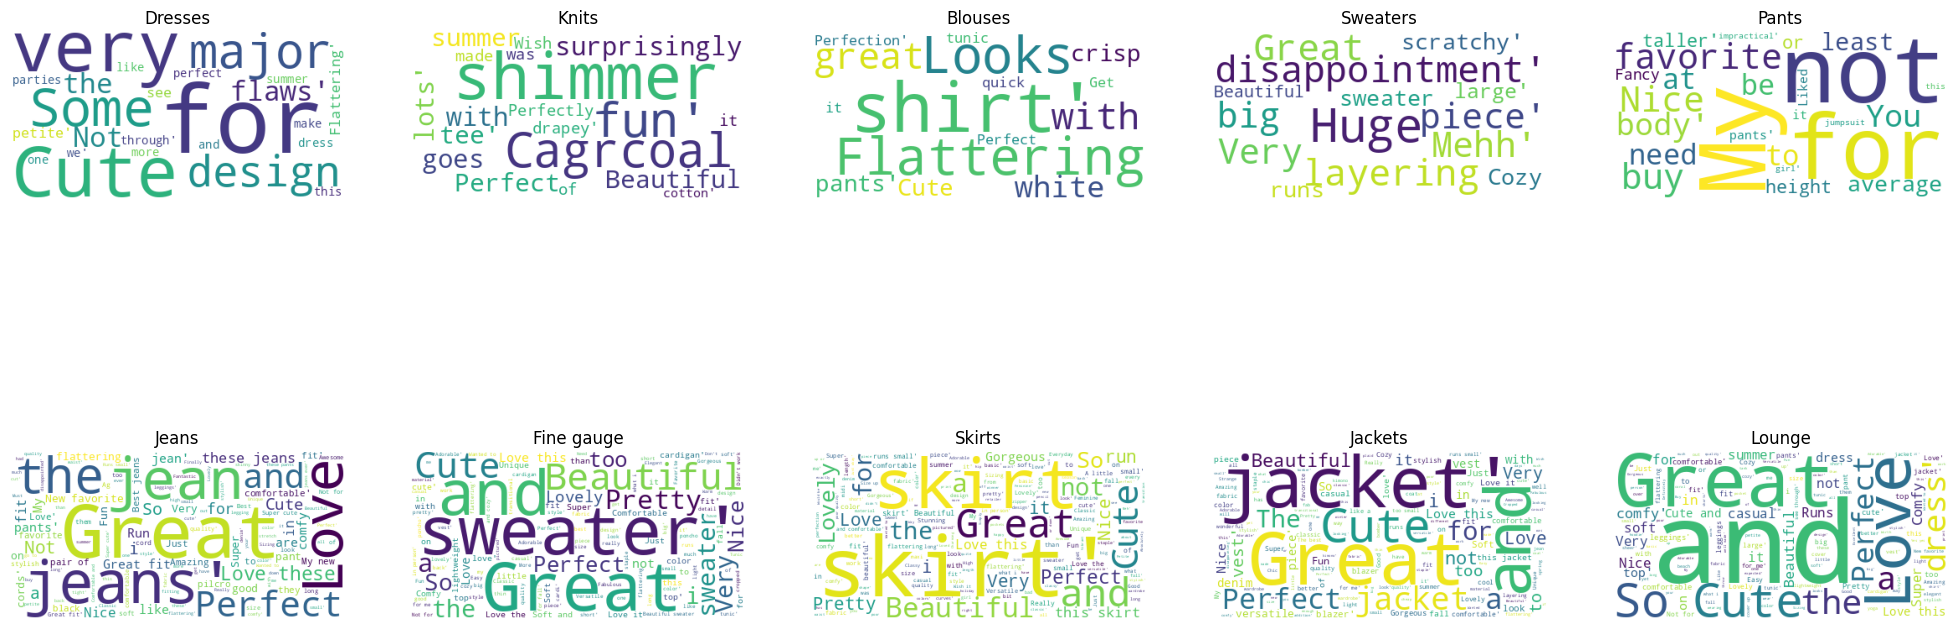

In [ ]:
fig, axs = plt.subplots(2, 5, figsize = (25, 10))
for i, ax in zip(topest.keys()[:10], axs.ravel()):
    wc = WordCloud(background_color = 'white', stopwords = ['through', 'we', 'Please', 'but']).generate(str(review[review['Class Name'] == i]['Title'].values))
    ax.set_title(i)
    ax.axis("off")
    ax.imshow(wc)

## Целевая переменная и формирование обучающего датасета

In [ ]:
review['Recommended IND'].value_counts()

,count
Recommended IND,
1,16087
0,3575


In [ ]:
dress_review = review[review['Class Name'] == 'Dresses']
dress_index = dress_review['Clothing ID'].value_counts()

In [ ]:
dress_review.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses
10,10,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,3,0,14,General,Dresses,Dresses


In [ ]:
recommend_text = dress_review[['Review Text', 'Recommended IND']]
recommend_text.rename(columns={'Review Text': 'text',
                   'Recommended IND': 'label'},
          inplace=True, errors='raise')
recommend_text

<ipython-input-10-d614eeecf02f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommend_text.rename(columns={'Review Text': 'text',


,text,label
2,I had such high hopes for this dress and reall...,0
5,"I love tracy reese dresses, but this one is no...",0
8,I love this dress. i usually get an xs but it ...,1
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",1
10,Dress runs small esp where the zipper area run...,0
...,...,...
23478,I was surprised at the positive reviews for th...,0
23481,I was very happy to snag this dress at such a ...,1
23483,"This fit well, but the top was very see throug...",0
23484,I bought this dress for a wedding i have this ...,1


На мой взгляд, текст достаточно чистый. Я читал, что предобработка для моделей на базе архетектуры трансформер является достаточно избыточным делом, если текст не очень грязный.

Я покажу, что умею делать предобработку, так как это требование задания, но при обучении буду использовать исходный текст. Только если качество обученной модели меня будет не устраиваться, вернусь к этому вопросу.

In [ ]:
recommend_text.text.describe()

,text
count,5371
unique,5370
top,I purchased this and another eva franco dress ...
freq,2


## Предобработка текста

In [ ]:
def preprocess_text(text):
    # Удаление специальных символов и цифр
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Пример использования

recommend_text['clean_text'] = recommend_text['text'].apply(preprocess_text)

<ipython-input-11-212c2fccbc3a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommend_text['clean_text'] = recommend_text['text'].apply(preprocess_text)


Эта функция выполняет следующие шаги предобработки:

Удаляет все символы, которые не являются буквами английского алфавита или пробелами. Это включает в себя удаление цифр, знаков препинания и специальных символов.
Заменяет множественные пробелы на один пробел и удаляет лишние пробелы в начале и конце строки.

In [ ]:
recommend_text.head()

,text,label,clean_text
2,I had such high hopes for this dress and reall...,0,I had such high hopes for this dress and reall...
5,"I love tracy reese dresses, but this one is no...",0,I love tracy reese dresses but this one is not...
8,I love this dress. i usually get an xs but it ...,1,I love this dress i usually get an xs but it r...
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",1,Im and lbs i ordered the s petite to make sure...
10,Dress runs small esp where the zipper area run...,0,Dress runs small esp where the zipper area run...


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased", padding = 'max_length', truncation = True)
dataset = Dataset.from_pandas(recommend_text)

# Определение Data Collator
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Применяем функцию токенизации к датасетам
train_dataset = train_dataset.map(tokenize_function, batched = True)
val_dataset = val_dataset.map(tokenize_function, batched = True)

# Устанавливаем формат данных
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/4296 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4296
})

In [ ]:
# Функция для вычисления метрик качества обучения модели
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'eval_f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Загрузка предобученной модели BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Настройка обучения
training_args = TrainingArguments(
    "bert_result",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Сохраняем модель каждую эпоху
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Загружаем лучшую модель в конце обучения
    metric_for_best_model="f1",  # Метрика для выбора лучшей модели
    greater_is_better=True,  # True, если большее значение метрики лучше
    remove_unused_columns=True,  # Позволяет не удалять вспомогательные колонки из объекта Dataset
    push_to_hub=True,
    warmup_steps=500,
    hub_model_id="data-silence/dress-classifier",
    hub_strategy="every_save",
    )

# Создание объекта Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,0.296524,0.881744,0.893953,0.894197,0.893953
2,0.344200,0.274039,0.913317,0.916279,0.913302,0.916279
3,0.344200,0.290381,0.909551,0.906047,0.917398,0.906047
4,0.139700,0.310348,0.923140,0.923721,0.922712,0.923721
5,0.139700,0.348981,0.925987,0.925581,0.926474,0.925581


TrainOutput(global_step=1345, training_loss=0.19392688992298227, metrics={'train_runtime': 498.5014, 'train_samples_per_second': 43.089, 'train_steps_per_second': 2.698, 'total_flos': 5651625469132800.0, 'train_loss': 0.19392688992298227, 'epoch': 5.0})

In [ ]:
# Оценка модели
trainer.evaluate()

{'eval_f1': 0.9259865995814843,
 'eval_loss': 0.3489808738231659,
 'eval_accuracy': 0.9255813953488372,
 'eval_precision': 0.9264741757708169,
 'eval_recall': 0.9255813953488372,
 'eval_runtime': 7.0155,
 'eval_samples_per_second': 153.233,
 'eval_steps_per_second': 9.693,
 'epoch': 5.0}

In [ ]:
trainer.push_to_hub("data-silence/dress-classifier")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1724529614.94544b47976e.2444.4:   0%|          | 0.00/560 [00:00<?, ?B/s]

events.out.tfevents.1724529071.94544b47976e.2444.3:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/data-silence/dress-classifier/commit/11d1f5f0033567b6163dee93e2193d1a1b929a6a', commit_message='data-silence/dress-classifier', commit_description='', oid='11d1f5f0033567b6163dee93e2193d1a1b929a6a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
inputs = tokenizer(val_dataset['text'], padding=True, truncation=True, return_tensors="pt").to(model.device)


model.eval()


with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits


predicted_labels = torch.argmax(predictions, dim=1)

In [ ]:
# Перемещаем тензор на CPU и преобразовываем его в массив NumPy
predicted_labels_cpu = predicted_labels.cpu().numpy()

# Теперь используем массив NumPy в scikit-learn
confusion_matrix(val_dataset['label'], predicted_labels_cpu)
accuracy_score(val_dataset['label'], predicted_labels_cpu)
print(classification_report(val_dataset['label'], predicted_labels_cpu))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       206
           1       0.96      0.95      0.95       869

    accuracy                           0.93      1075
   macro avg       0.88      0.89      0.88      1075
weighted avg       0.93      0.93      0.93      1075



Таким образом, метрики качества на валидации посчитаны тремя способами:
1. через созданную функцию compute_metrics и автоматическую оценку качества через неё  на каждой эпохе трейрером,
2. через trainer.evaluate() по завершению этапа обучения модели
3. через классический подход, когда обученная модель применяется к валидационному датасету и истиные и прогнозные классы передаются в методы scikit-learn

# Бонус: Предсказываем рейтинг

In [ ]:
review.Rating.value_counts()

,count
Rating,
5,10858
4,4289
3,2464
2,1360
1,691


Ну да, классы несбалансированные. Хотя и они и в прошлой задаче были такими. Теперь задача не бинарной, а многоклассовой классификации, но при её решении черзе Trainer это особо ничего не меняет (кроме инициализации модели).

Я решил сначала обучить модель без учета весов классов, а потом адаптировать решение с ним, лучшее решение грузить на Hagging Face

In [ ]:
# ## Целевая переменная и формирование обучающего датасета
rating_text = review[['Review Text', 'Rating']]
rating_text.rename(columns={'Review Text': 'text',
                   'Rating': 'label'},
          inplace=True, errors='raise')
rating_text

# При инициализации модели мы задали 5 классов у модели - Трейнер ожидает метки в диапазоне [0,4], а в реальном датасете диапазон [1,5]. Без вычитания единицы будет ошибка
rating_text['label'] = rating_text['label'] - 1

# ## Предобработка текста (опционально)
# ... (код предобработки текста из предыдущего примера, если нужен)

# ## Токенизация
dataset = Dataset.from_pandas(rating_text)
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

<ipython-input-7-0c6764abc689>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_text.rename(columns={'Review Text': 'text',
<ipython-input-7-0c6764abc689>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_text['label'] = rating_text['label'] - 1


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched = True)
val_dataset = val_dataset.map(tokenize_function, batched = True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/15729 [00:00<?, ? examples/s]

Map:   0%|          | 0/3933 [00:00<?, ? examples/s]

In [ ]:
# ## Загрузка и настройка модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)  # 5 labels for Rating (1-5)

# ## Определение весов классов (для несбалансированных данных)
class_weights = compute_class_weight('balanced', classes=np.unique(rating_text['label']), y=rating_text['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(model.device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class_weights

tensor([5.6909, 2.8915, 1.5959, 0.9169, 0.3622])

In [ ]:
# Функция для вычисления метрик качества обучения модели
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'eval_f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# ## Настройка обучения (с учетом весов классов)
training_args = TrainingArguments(
    "bert_result_rating",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=True,
    push_to_hub=True,
    warmup_steps=500,
    hub_model_id="data-silence/rating-classifier",
    hub_strategy="every_save",
)

# ## Создание объекта Trainer (с учетом весов классов)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # Make sure compute_metrics is defined
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# ## Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,1.032600,0.809554,0.635441,0.670735,0.638275,0.670735
2,0.680100,0.750758,0.666783,0.688787,0.666676,0.688787
3,0.531300,0.837289,0.672939,0.670989,0.677432,0.670989
4,0.389500,0.970455,0.667754,0.673023,0.664887,0.673023
5,0.285700,1.098883,0.670843,0.674549,0.668449,0.674549


TrainOutput(global_step=4920, training_loss=0.5578020607552877, metrics={'train_runtime': 1719.2898, 'train_samples_per_second': 45.743, 'train_steps_per_second': 2.862, 'total_flos': 2.069292631408128e+16, 'train_loss': 0.5578020607552877, 'epoch': 5.0})

In [ ]:
# ## Оценка модели
trainer.evaluate()

{'eval_f1': 0.6729394584845081,
 'eval_loss': 0.8372889757156372,
 'eval_accuracy': 0.6709890668700738,
 'eval_precision': 0.6774322690741015,
 'eval_recall': 0.6709890668700738,
 'eval_runtime': 25.4224,
 'eval_samples_per_second': 154.706,
 'eval_steps_per_second': 9.676,
 'epoch': 5.0}

Чтобы использовать Trainer из библиотеки Hugging Face для дообучения модели с несбалансированными категориями, нам нужно будет передать весовую функцию потерь в Trainer.

В Trainer нет прямой опции для указания весов классов, но это можно сделать, сделав кастомный Trainer, в котором нужно создать метод вычисления потерь на несбалансированных данных.

В качестве функции потерь для этой задачи используется CrossEntropyLoss с параметром weight.

Вес каждого класса можно определить как обратную пропорцию его частоты: class_weight = total_samples / (num_classes * count_per_class). Я воспользовался готовым решением из sklearn.

Кроме того, при оценке модели используют метрики, которые не подвержены влиянию дисбаланса, такие как F1-score, Precision-Recall Curve или ROC-AUC. Считается, что эти метрики дадут более точное представление о производительности модели на несбалансированных данных. Я буду использовать f1.

In [ ]:
# Define a custom loss function outside the Trainer
class CustomLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        outputs = model(**inputs)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device)) # Assuming class_weights is defined
        loss = loss_fn(outputs.logits, inputs['labels'])
        return (loss, outputs) if return_outputs else loss

In [ ]:
# ## Настройка обучения (с учетом весов классов)
training_args = TrainingArguments(
    "bert_result_rating",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=True,
    push_to_hub=True,
    warmup_steps=500,
    hub_model_id="data-silence/rating-classifier",
    hub_strategy="every_save",
)



# ## Создание объекта Trainer (с учетом весов классов)
# Create the Trainer with the custom loss class
weighted_trainer = CustomLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# ## Обучение модели
weighted_trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.614300,1.558705,0.665750,0.671498,0.661568,0.671498
2,0.421800,1.912842,0.657038,0.666667,0.651793,0.666667
3,0.249500,2.176535,0.662922,0.664378,0.663149,0.664378


TrainOutput(global_step=2952, training_loss=0.4112033869838973, metrics={'train_runtime': 1045.1384, 'train_samples_per_second': 45.149, 'train_steps_per_second': 2.825, 'total_flos': 1.2415755788448768e+16, 'train_loss': 0.4112033869838973, 'epoch': 3.0})

In [ ]:
# ## Оценка модели
weighted_trainer.evaluate()

{'eval_f1': 0.6657502253451728,
 'eval_loss': 1.5587047338485718,
 'eval_accuracy': 0.6714975845410628,
 'eval_precision': 0.6615680476488031,
 'eval_recall': 0.6714975845410628,
 'eval_runtime': 25.7145,
 'eval_samples_per_second': 152.949,
 'eval_steps_per_second': 9.567,
 'epoch': 3.0}

В общем, все мои ухищрения по донастройке трейнера на решение этой задачи оказались напрасными: трейнер с настройками по умолчанию учит определять несбалансированные классы чуть лучше, чем моя кастомная реализация. Поэтому сохраняем на HF обучение с настройками по умолчанию.

In [ ]:
# ## Сохранение модели
trainer.push_to_hub("data-silence/rating-classifier")

events.out.tfevents.1724535239.9fa1dcb15539.2980.4:   0%|          | 0.00/560 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/data-silence/rating-classifier/commit/db42250bb2b8c647319913fac6370b0450e3dcd2', commit_message='data-silence/rating-classifier', commit_description='', oid='db42250bb2b8c647319913fac6370b0450e3dcd2', pr_url=None, pr_revision=None, pr_num=None)